In [4]:
import numpy as np
np.random.seed(0)

from sklearn import datasets

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.isotonic import IsotonicRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def scale_data(data, columns, scaler):
    for col in columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data
  
def one_hot_obj_feature(df,features):
    new_df=pd.get_dummies(df,columns=features,sparse=True)
    return new_df

In [20]:

from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

In [8]:
all_df = pd.read_csv("MLFinalProjectDataset/train_data.csv")
train_df = all_df.sample(frac=0.01, random_state=42)
# df=df.sample(frac = 0.5) 
min_max_scaler = preprocessing.MinMaxScaler()
df=scale_data(train_df,list(train_df.columns)[:-1], preprocessing.MaxAbsScaler())
test_df = all_df.drop(df.index).sample(frac=0.02, random_state=42)
test_df=scale_data(test_df,list(test_df.columns)[:-1], preprocessing.MaxAbsScaler())

In [9]:
class balance:
    def __init__(self,x,y,model):
        self.x=x
        self.y=y
        self.model=model
    def fit(self):
        return self.model.fit_resample(self.x,self.y)

class Classifier:
    """
        train_data: tuple(train_features, train_tags)
        test_data: tuple(test_features)
    """
    def __init__(self, x, y, model):
        self.train_sparse_matrix = x
        self.train_tags = y
        self.model = model
        self.is_learned = False

    def fit(self):
        self.model.fit(self.train_sparse_matrix, self.train_tags)
        self.is_learned = True

    def predict(self,t):
        if not self.is_learned:
            self.fit()
        return self.model.predict(t)
  

In [11]:
df_x=df.drop("clicked",axis=1)
df_y=df["clicked"]
rus = balance(df_x,df_y,RandomUnderSampler(random_state=42, replacement=True))# fit predictor and target variable
x_rus, y_rus = rus.fit()
ros=balance(df_x,df_y,RandomOverSampler(random_state=42))
x_ros, y_ros=ros.fit()
smote = balance(df_x,df_y,SMOTE())
x_smote, y_smote=smote.fit()
nm = balance(df_x,df_y,NearMiss())
x_nm,y_nm=nm.fit()

x_rus, y_rus=x_rus.to_numpy(), y_rus.to_numpy()
x_ros, y_ros=x_ros.to_numpy(), y_ros.to_numpy()
x_smote, y_smote=x_smote.to_numpy(), y_smote.to_numpy()
x_nm,y_nm=x_nm.to_numpy(),y_nm.to_numpy()

balanced_all_fetuers=[x_rus, y_rus,x_ros, y_ros,x_smote, y_smote,x_nm,y_nm]
method=["rus","ros","smote","nm"]

df_x=test_df.drop("clicked",axis=1)
df_y=test_df["clicked"]
rus = balance(df_x,df_y,RandomUnderSampler(random_state=42, replacement=True))# fit predictor and target variable
x_rus, y_rus = rus.fit()
ros=balance(df_x,df_y,RandomOverSampler(random_state=42))
x_ros, y_ros=ros.fit()
smote = balance(df_x,df_y,SMOTE())
x_smote, y_smote=smote.fit()
nm = balance(df_x,df_y,NearMiss())
x_nm,y_nm=nm.fit()

x_rus, y_rus=x_rus.to_numpy(), y_rus.to_numpy()
x_ros, y_ros=x_ros.to_numpy(), y_ros.to_numpy()
x_smote, y_smote=x_smote.to_numpy(), y_smote.to_numpy()
x_nm,y_nm=x_nm.to_numpy(),y_nm.to_numpy()

test_balanced_all_fetuers=[x_rus, y_rus,x_ros, y_ros,x_smote, y_smote,x_nm,y_nm]
method={'rus':0, 'ros':1, 'smote':2, 'nm': 3}

In [5]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):
    """Compute reliability curve

    Reliability curves allow checking if the predicted probabilities of a
    binary classifier are well calibrated. This function returns two arrays
    which encode a mapping from predicted probability to empirical probability.
    For this, the predicted probabilities are partitioned into equally sized
    bins and the mean predicted probability and the mean empirical probabilties
    in the bins are computed. For perfectly calibrated predictions, both
    quantities whould be approximately equal (for sufficiently many test
    samples).

    Note: this implementation is restricted to binary classification.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels (0 or 1).

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class or confidence values. If normalize is False, y_score must be in
        the interval [0, 1]

    bins : int, optional, default=10
        The number of bins into which the y_scores are partitioned.
        Note: n_samples should be considerably larger than bins such that
              there is sufficient data in each bin to get a reliable estimate
              of the reliability

    normalize : bool, optional, default=False
        Whether y_score needs to be normalized into the bin [0, 1]. If True,
        the smallest value in y_score is mapped onto 0 and the largest one
        onto 1.


    Returns
    -------
    y_score_bin_mean : array, shape = [bins]
        The mean predicted y_score in the respective bins.

    empirical_prob_pos : array, shape = [bins]
        The empirical probability (frequency) of the positive class (+1) in the
        respective bins.


    References
    ----------
    .. [1] `Predicting Good Probabilities with Supervised Learning
            <http://machinelearning.wustl.edu/mlpapers/paper_files/icml2005_Niculescu-MizilC05.pdf>`_

    """
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [17]:
bins = 25

SVM_X_train = balanced_all_fetuers[2*method['nm']]
SVM_X_test = test_balanced_all_fetuers[2*method['nm']]
SVM_y_train = balanced_all_fetuers[2*method['nm']+1]
SVM_y_cy_test = test_balanced_all_fetuers[2*method['nm']+1]

LR_X_train = balanced_all_fetuers[2*method['nm']]
LR_X_test = test_balanced_all_fetuers[2*method['nm']]
LR_y_train = balanced_all_fetuers[2*method['nm']+1]
LR_y_test = test_balanced_all_fetuers[2*method['nm']+1]

XG_X_train = balanced_all_fetuers[2*method['ros']]
XG_X_test = test_balanced_all_fetuers[2*method['ros']]
XG_y_train = balanced_all_fetuers[2*method['ros']+1]
XG_y_test = test_balanced_all_fetuers[2*method['ros']+1]

X_trains = {"Logistic regression": LR_X_train,
            "Random Forest": XG_X_train,
            "XGBClassifier": XG_X_train
            }

y_trains = {"Logistic regression": LR_y_train,
            "Random Forest": XG_y_train,
            "XGBClassifier": XG_y_train
            }

X_tests = {"Logistic regression": LR_X_test,
            "Random Forest": XG_X_test,
            "XGBClassifier": XG_X_test
            }

y_tests = {"Logistic regression": LR_y_test,
            "Random Forest": XG_y_test,
            "XGBClassifier": XG_y_test
            }

In [25]:
classifiers = {"Logistic regression": LogisticRegression(random_state=0,C=0.1, max_iter=10000),
               "Random Forest": RandomForestClassifier(n_estimators=100),
               "XGBClassifier": XGBClassifier()
               }
# "SVM": Classifier(t_X, t_Y,svm.SVC(C=10)),

In [26]:
reliability_scores = {}
y_score = {}
for method, clf in classifiers.items():
    clf.fit(X_trains[method], y_trains[method])
    if method == "SVC":
        # Use SVC scores (predict_proba returns already calibrated probabilities)
        y_score[method] = clf.decision_function(X_tests[method])[:, 0]
        reliability_scores[method] = \
            reliability_curve(y_test, y_score[methods[method]], bins=bins, normalize=True)
    else:
        y_score[method] = clf.predict_proba(X_tests[method])[:, 1]
        reliability_scores[method] = \
            reliability_curve(y_tests[method], y_score[method], bins=bins, normalize=False)

[22:58:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


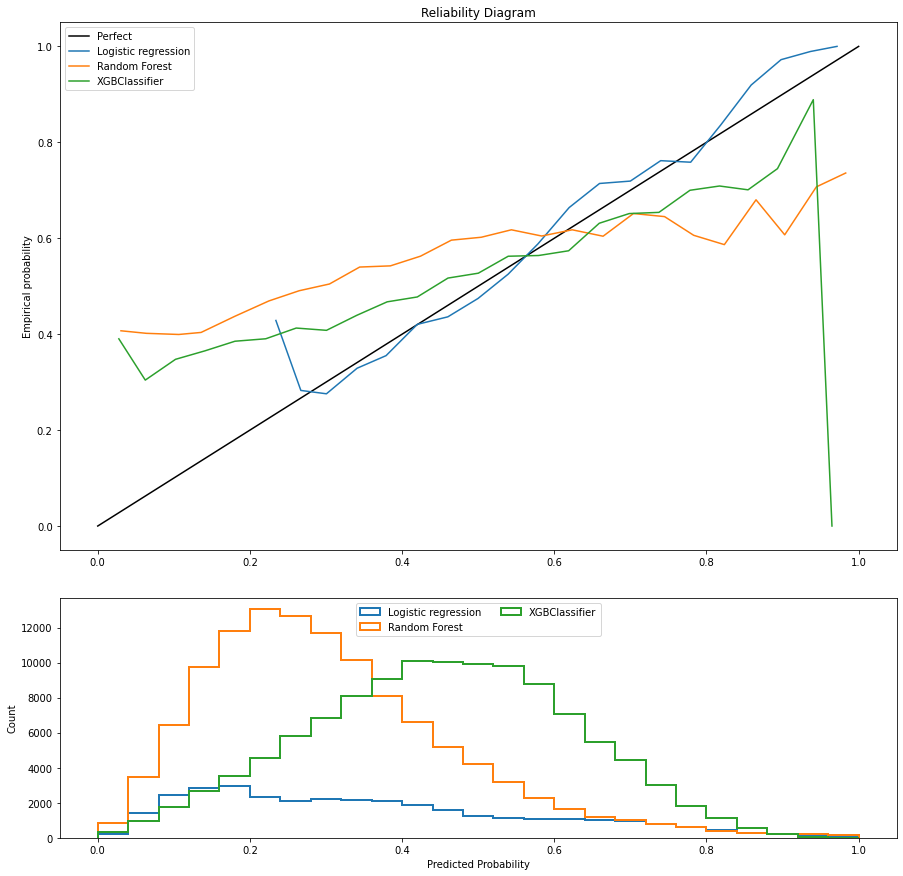

In [34]:
plt.figure(0, figsize=(15, 15))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect")
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.title("Reliability Diagram")
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)

plt.show();

Logistic regression returns well-calibrated probabilities close to the "perfect" line
